## study_styletransfer.ipynb

In [ ]:
# https://www.tensorflow.org/tutorials/generative/style_transfer?hl=ko

# https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

In [ ]:
!pip install tensorflow

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [3]:
# VGG19 의 모델을 가져왔다. 

network = tf.keras.applications.VGG19(include_top = False, weights = "imagenet")

In [4]:
# summary로 구성을 확인했다.

network.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [5]:
len(network.layers)

22

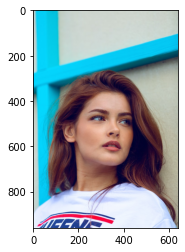

In [6]:
content_image = tf.keras.preprocessing.image.load_img("g2.jpg")
plt.imshow(content_image)

In [7]:
type(content_image)

PIL.JpegImagePlugin.JpegImageFile

In [8]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)

In [9]:
type(content_image), content_image.shape, content_image.min(), content_image.max()

(numpy.ndarray, (960, 640, 3), 0.0, 255.0)

In [10]:
# 정규화 
content_image = content_image / 255

In [11]:
content_image.min(), content_image.max()

(0.0, 1.0)

In [12]:
content_image

array([[[0.7647059 , 0.8039216 , 0.77254903],
        [0.7607843 , 0.8       , 0.76862746],
        [0.76862746, 0.79607844, 0.7647059 ],
        ...,
        [0.7294118 , 0.76862746, 0.7254902 ],
        [0.7254902 , 0.7647059 , 0.72156864],
        [0.72156864, 0.7607843 , 0.7176471 ]],

       [[0.7647059 , 0.8039216 , 0.77254903],
        [0.7607843 , 0.8       , 0.76862746],
        [0.76862746, 0.79607844, 0.7647059 ],
        ...,
        [0.7254902 , 0.7647059 , 0.72156864],
        [0.7254902 , 0.7647059 , 0.72156864],
        [0.7254902 , 0.7647059 , 0.72156864]],

       [[0.7647059 , 0.8039216 , 0.77254903],
        [0.7607843 , 0.8       , 0.76862746],
        [0.7607843 , 0.8       , 0.7647059 ],
        ...,
        [0.72156864, 0.7607843 , 0.7176471 ],
        [0.7254902 , 0.7647059 , 0.72156864],
        [0.7254902 , 0.7647059 , 0.72156864]],

       ...,

       [[0.91764706, 0.9490196 , 1.        ],
        [0.91764706, 0.9490196 , 1.        ],
        [0.91764706, 0

In [13]:
# 텐서플로우 형태 중 배치(batch)를 넣어줘서 축을 하나 더 넣어주는 것이다.
content_image = content_image[tf.newaxis, :]

In [14]:
content_image.shape

(1, 960, 640, 3)

In [15]:
style_image = tf.keras.preprocessing.image.load_img("tarsila_amaral.jpg")

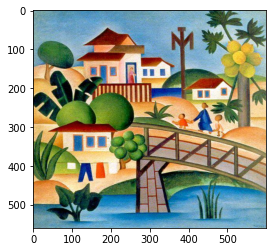

In [16]:
plt.imshow(style_image)

In [17]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]
style_image.shape

(1, 560, 600, 3)

In [18]:
content_layers = ["block4_conv2"]
style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]

In [19]:
# 레이어들을 추출해 내는 것! 
# 레이어 형태를 리스트 형태로 뽑는 것! 
[network.get_layer(name).output for name in style_layers]

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [20]:
network.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [21]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top = False, weights = "imagenet")
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    network = tf.keras.Model(inputs = [vgg.input], outputs = outputs)

    return network

In [22]:
style_extractor = vgg_layers(style_layers)

In [23]:
style_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [24]:
len(style_extractor.layers)

18

In [25]:
style_extractor.outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [26]:
style_outputs = style_extractor(style_image)

In [27]:
len(style_outputs)

5

In [28]:
style_outputs[1]

<tf.Tensor: shape=(1, 280, 300, 128), dtype=float32, numpy=
array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          7.1451001e+00, 0.0000000e+00, 1.2458383e+01],
         [0.0000000e+00, 0.0000000e+00, 1.6780980e+00, ...,
          2.6414454e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 1.1416001e+00, ...,
          5.3857527e+00, 0.0000000e+00, 1.1649452e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 1.7971697e+00, ...,
          5.8314395e+00, 0.0000000e+00, 1.2675005e+00],
         [0.0000000e+00, 0.0000000e+00, 2.0207396e+00, ...,
          6.5748844e+00, 0.0000000e+00, 2.6461127e+00],
         [0.0000000e+00, 0.0000000e+00, 7.9473062e+00, ...,
          1.3143226e+01, 0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 4.9902220e+00, 0.0000000e+00, ...,
          7.3128695e+00, 5.7628685e-01, 1.3347646e+01],
         [0.0000000e+00, 5.0576692e+00, 7.9425313e-02, ...,
          0.0000000e+00, 3.5877329e-01, 0.0000000e+0

In [29]:
style_outputs[0].shape, style_outputs[1].shape, style_outputs[2].shape, style_outputs[3].shape, style_outputs[4].shape 

(TensorShape([1, 560, 600, 64]),
 TensorShape([1, 280, 300, 128]),
 TensorShape([1, 140, 150, 256]),
 TensorShape([1, 70, 75, 512]),
 TensorShape([1, 35, 37, 512]))

In [30]:
def gram_matrix(layer_activation):
    result = tf.linalg.einsum("bijc, bijd->bcd", layer_activation, layer_activation)
    input_shape = tf.shape(layer_activation)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

    return result / num_locations

In [31]:
gram_matrix(style_outputs[0])

<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[0.6309873 , 0.28931645, 0.2851602 , ..., 0.10537571,
         0.369587  , 0.45012602],
        [0.28931645, 0.24121155, 0.18381076, ..., 0.03157695,
         0.1959414 , 0.2171576 ],
        [0.2851602 , 0.18381076, 0.16743274, ..., 0.02779872,
         0.1941035 , 0.22709455],
        ...,
        [0.10537571, 0.03157695, 0.02779872, ..., 0.0829746 ,
         0.06948005, 0.06642946],
        [0.369587  , 0.1959414 , 0.1941035 , ..., 0.06948005,
         0.2868263 , 0.31854072],
        [0.45012602, 0.2171576 , 0.22709455, ..., 0.06642946,
         0.31854072, 0.37468502]]], dtype=float32)>

In [43]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {
            content_name : value for content_name,
            value in zip(self.content_layers, content_outputs)
        }
        style_dict = {
            style_name : value for style_name,
            value in zip(self.style_layers, style_outputs)
        }
        return {"content": content_dict, "style": style_dict}


In [44]:
style_layers, content_layers

(['block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1'],
 ['block4_conv2'])

In [45]:
extractor = StyleContentModel(style_layers, content_layers)

In [46]:
results = extractor(content_image)

In [ ]:
results

In [42]:
for key, value in results.items():
    print(key, value.keys())

content dict_keys(['block4_conv2'])
style dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [48]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

In [49]:
len(style_targets), len(content_targets)

(5, 1)

In [50]:
new_image = tf.Variable(content_image)

In [52]:
content_weight = 1
style_weight = 100

In [54]:
optimizer = tf.optimizers.Adam(learning_rate = 0.02)

In [57]:
# 학습 시작

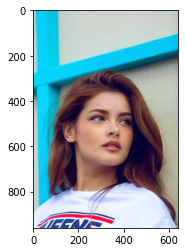

In [58]:
plt.imshow(tf.squeeze(content_image, axis = 0))

Epoch 5 | content loss: 459448.15625 | style loss: 32535201792.0 | total loss 3253520826368.0


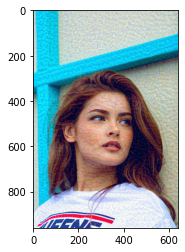

Epoch 10 | content loss: 486484.59375 | style loss: 15583599616.0 | total loss 1558360489984.0


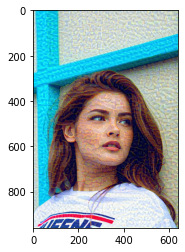

In [63]:
epochs = 500
print_every = 5

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        outputs = extractor(new_image)

        content_outputs = outputs["content"]
        style_outputs = outputs["style"]

        content_loss = tf.add_n([
            tf.reduce_mean(
                (content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()
        ])
        style_loss = tf.add_n([
            tf.reduce_mean(
                (style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()
        ])

        total_loss = content_loss * content_weight  + style_loss * style_weight
    
    gradient = tape.gradient(total_loss, new_image)
    optimizer.apply_gradients([(gradient, new_image)])

    new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

    if (epoch + 1) % print_every == 0:
        print("Epoch {} | content loss: {} | style loss: {} | total loss {}"
        .format(epoch + 1, content_loss, style_loss, total_loss))
        plt.imshow(tf.squeeze(new_image, axis = 0))
        plt.show()
